In [322]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Предобработка (часть 1)

In [323]:
def rename_cols(old_name, one_hot):
    new_cols = {}
    for column in one_hot:
        new_cols[column] = old_name + ": " + column
    return one_hot.rename(columns=new_cols)

In [324]:
def add_cols(df, add_df):
    for column in add_df.columns:
        df[column] = add_df[column]

In [325]:
def preprocessing(path):
   df = pd.read_csv(path)
   useles_columns = ['№', 'Модель (полное название)', 'Модель процессора', 'Год выпуска процессора', 'Модель встроенной видеокарты', 'Тип (марка) куллера материнской платы', 'Браузер для тестов','Исполнитель', 'Модель дискретной видеокарты']
   df = df.drop(labels = useles_columns,axis = 1)
   new_names = {'Объем видеопамяти (Гб)': 'Объем видеопамяти (Гб) [дискретной]',
                     'Объем видеопамяти (Гб).1': 'Объем видеопамяти (Гб) [встроенной]'}

   df = df.rename(columns=new_names)
   df.dropna(subset=['Количество ядер',
      'Количество логических процессоров (потоков)',
      'Тактовая частота процессора (ГГц)',
      'Максимальная тактовая частота (ГГц)', 'Объем кэша L2 процессора (Кб)',
      'Объем кэша L3 процессора (Кб)', 'Размер оперативной памяти (Гб)',
      'Частота оперативной памяти (МГц)',
      'Учебный', 
      'Развлекательный', 
      'Эталон'],
      inplace=True)

   num_features = ['Количество ядер', 'Количество логических процессоров (потоков)', 'Тактовая частота процессора (ГГц)','HDD','SSD' , 'Объем видеопамяти (Гб) [встроенной]', 'Объем видеопамяти (Гб) [дискретной]']
   cat_features = ['Вид графического ускорителя (Дискретный / Встроенный)', 'Тип видеопамяти', 'Размер оперативной памяти (Гб)']

   obj_df = df[num_features].copy()
   obj_df['Объем видеопамяти (Гб) [дискретной]'] = pd.to_numeric(obj_df['Объем видеопамяти (Гб) [дискретной]'], errors='coerce')
   obj_df['Объем видеопамяти (Гб) [встроенной]'] = pd.to_numeric(obj_df['Объем видеопамяти (Гб) [встроенной]'], errors='coerce')
   obj_df = obj_df.fillna({"Объем видеопамяти (Гб) [встроенной]": 0,
                     "Объем видеопамяти (Гб) [дискретной]": 0})

   df[num_features] = obj_df
   graph_acc = pd.get_dummies(df['Вид графического ускорителя (Дискретный / Встроенный)'])
   graph_acc.columns = graph_acc.columns.str.strip()
   graph_acc.loc[graph_acc['дискретный и встроенный'] == 1, ['встроенный', 'дискретный']] = 1
   graph_acc = graph_acc.drop(['дискретный и встроенный', 'встроенный'], axis=1)
   graph_acc = rename_cols('Наличие графического ускорителя', graph_acc)
   graph_acc = graph_acc.fillna(0)
   video_mem = pd.get_dummies(df['Тип видеопамяти'])
   video_mem = rename_cols('Тип видеопамяти', video_mem)

   RAM_size = (df['Размер оперативной памяти (Гб)'] // 8 > 0).astype(int)
   
   df = df.drop(cat_features, axis=1)
   add_cols(df, graph_acc)
   add_cols(df, video_mem)
   df['Оперативная память > 8'] = RAM_size

   benchmark_columns = ['Учебный', 'Развлекательный', 'Эталон']
   benchmark_df = df[benchmark_columns].dropna()
   benchmark_df['sum'] = benchmark_df[benchmark_columns].sum(axis=1)
   df['benchmark'] = benchmark_df['sum']
   return df

In [326]:
df = pd.read_csv(r"data/laptop_info.csv")
df.head()

,№,Модель (полное название),Модель процессора,Год выпуска процессора,Количество ядер,Количество логических процессоров (потоков),Тактовая частота процессора (ГГц),Максимальная тактовая частота (ГГц),Объем кэша L2 процессора (Кб),Объем кэша L3 процессора (Кб),...,Модель дискретной видеокарты,Объем видеопамяти (Гб),Модель встроенной видеокарты,Объем видеопамяти (Гб).1,Тип (марка) куллера материнской платы,Браузер для тестов,Учебный,Развлекательный,Эталон,Исполнитель
0,1,ASUS TUF Gaming A15 FA506II_FA506II,AMD Ryzen 5 4600H with Radeon Graphics,2020,6,12,3.0,4.0,3072,8192,...,NVIDIA GeForce GTX 1650 Ti,4.0,AMD Radeon(TM) Graphics,0.5,?,?,NaN,NaN,NaN,Пуха Анастасия
1,2,Lenovo IdeaPad S145-15IKB,Intel Core i3-8130U with Intel UHD Graphics 620,2018,2,4,2.2,3.4,512,4096,...,NaN,NaN,Intel UHD Graphics 620,0.128,NaN,NaN,2523.0,2299.0,2743.0,Гасымов Радик
2,3,Lenovo B590,Intel Core i3-3110M with Intel HD Graphics 4000,2012,2,4,2.4,2.4,256,3072,...,NVIDIA GeForce GT 720M,2.0,Intel HD Graphics 4000,0.64,NaN,NaN,4424.0,4371.0,4565.0,NaN
3,4,HP ProBook 455 G8 32N22EA,AMD Ryzen 5 5600U with Radeon Graphics,2021,6,12,2.3,4.2,3072,16384,...,NaN,NaN,AMD Radeon RX Vega 7,8,NaN,NaN,NaN,NaN,NaN,Тюлюбаев Артем
4,5,Acer Extensa 215-32,Pentium Silver N6000,2021,4,4,1.1,3.3,1536,4096,...,NaN,NaN,Intel UHD Graphics,8,NaN,NaN,NaN,NaN,NaN,NaN


In [327]:
df = preprocessing(r"data/laptop_info.csv")

## Предобработка (часть 2)

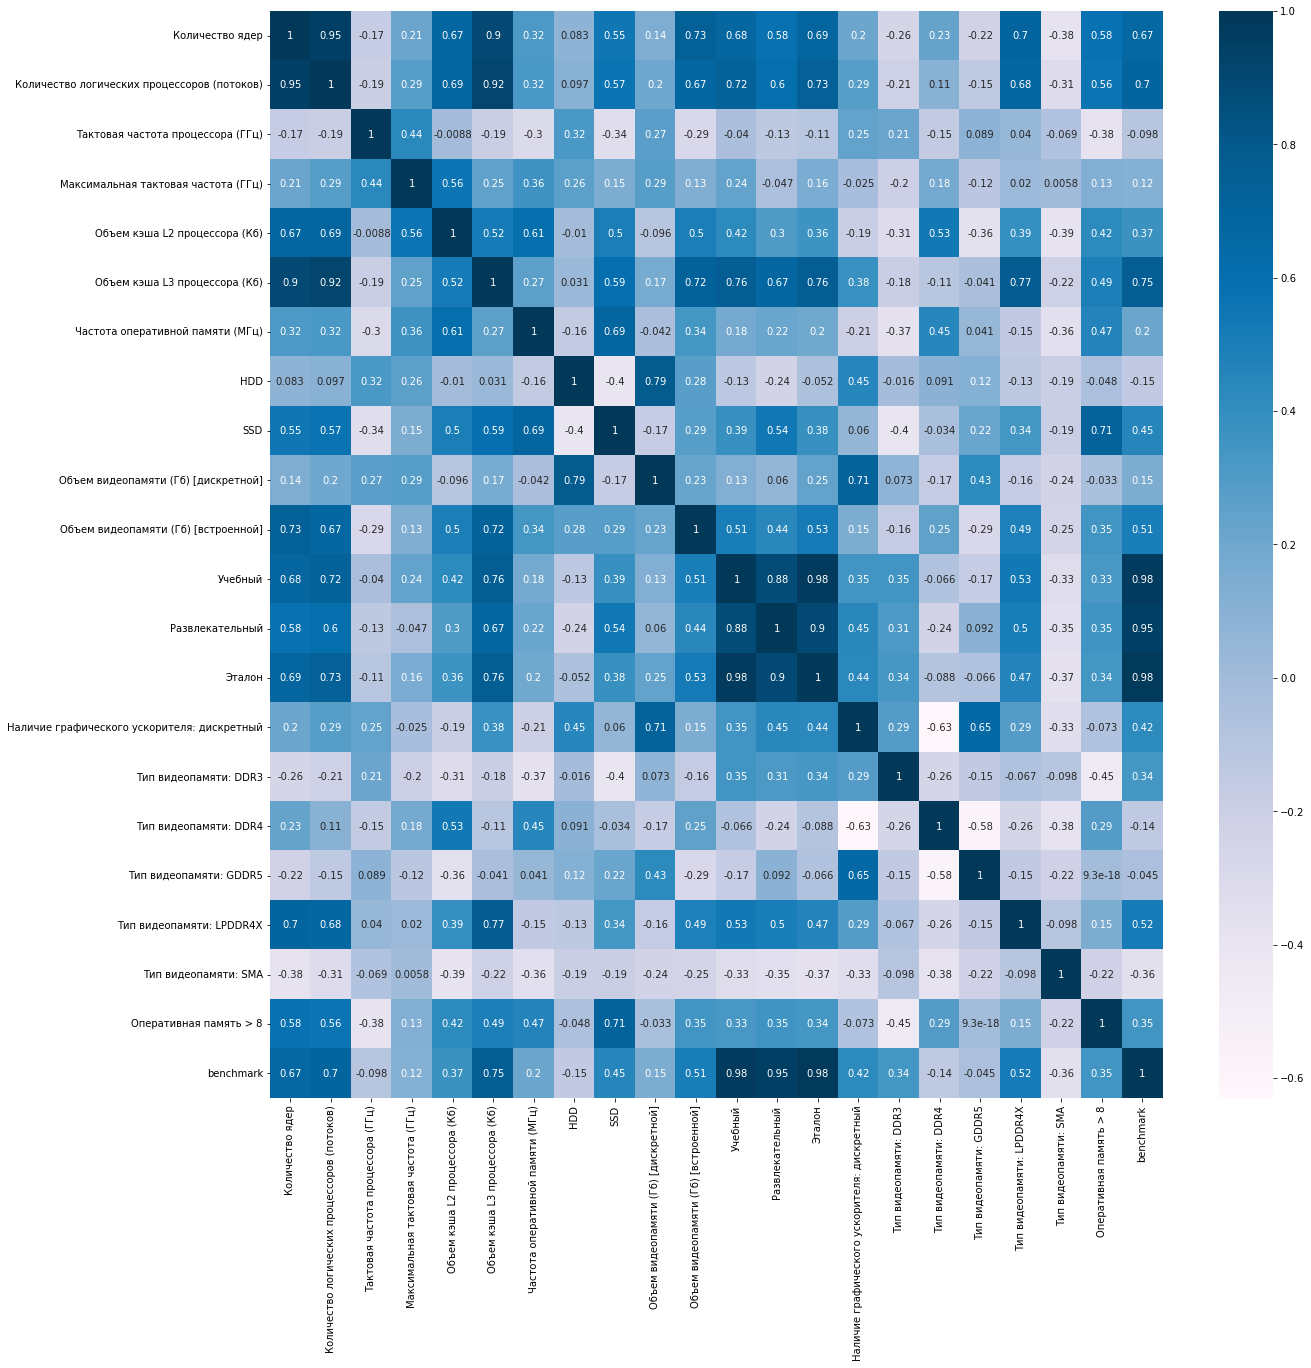

In [328]:
plt.figure(figsize=(20,20))  
p=sns.heatmap(df.corr(), annot=True,cmap =plt.cm.PuBu)

## Построение модели

In [329]:
import statsmodels.api as sm
from scipy import stats

In [330]:
labels = ['benchmark', 'Учебный', 'Развлекательный',
       'Эталон']
train = df.drop(labels, axis=1)
test = df.drop(train.columns, axis=1)

In [331]:
label = 'benchmark'

In [332]:
predictors = train.to_dict()
sorted_predictors = sorted(predictors, key=lambda x: abs(train[x].corr(test[label])))

In [333]:
for name in sorted_predictors:
    print(f"{name}: {abs(train[name].corr(test[label]))}")

Тип видеопамяти: GDDR5: 0.045063179864683195
Тактовая частота процессора (ГГц): 0.0982931581694683
Максимальная тактовая частота (ГГц): 0.1156359493246065
Тип видеопамяти: DDR4: 0.13810198979477906
HDD: 0.1464819183176351
Объем видеопамяти (Гб) [дискретной]: 0.14739017269259197
Частота оперативной памяти (МГц): 0.2048720374993193
Тип видеопамяти: DDR3: 0.3422700906254196
Оперативная память > 8: 0.3501385454716007
Тип видеопамяти: SMA: 0.36093349084959064
Объем кэша L2 процессора (Кб): 0.3734200290040194
Наличие графического ускорителя: дискретный: 0.42252373474601396
SSD: 0.4524746618539195
Объем видеопамяти (Гб) [встроенной]: 0.5051275590731006
Тип видеопамяти: LPDDR4X: 0.5167326477070092
Количество ядер: 0.6678102711978067
Количество логических процессоров (потоков): 0.7045529845028351
Объем кэша L3 процессора (Кб): 0.7530084700772977


In [334]:
train = train.drop('Количество ядер', axis=1)

In [335]:
x = train[sorted_predictors[:2]].values
y = test[label].values

In [336]:
def get_std_coefs(X, y):
    res = [0]
    X_z = X.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)
    Y_z = pd.DataFrame(y).apply(stats.zscore)
    model = sm.OLS(Y_z, X_z).fit()
    res.extend(model.params.tolist())
    # print(X)
    return pd.Series(res)

In [337]:
def get_pivot(df, model, param, label, num):
    pivot_test = pd.DataFrame()
    predictors = model.params.index.tolist()
    n = len(predictors)
    i = np.ones(n).astype(int) * num
    pivot_test['id'] = pd.Series(i)
    pivot_test['predictors'] = predictors
    pivot_test['b'] = model.params.tolist()
    pivot_test['std_err'] = model.bse.tolist()
    pivot_test['std coef'] = get_std_coefs(df[param], df[label])
    pivot_test['t'] = model.tvalues.tolist()
    pivot_test['lower interval'] = model.conf_int(alpha=0.05)[:][0].tolist()
    pivot_test['upper interval'] = model.conf_int(alpha=0.05)[:][1].tolist()
    return pivot_test.set_index('id')

In [338]:
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.stats.api as sms
#https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html
pred_list = []
Y = test[label]
pivot_df = pd.DataFrame()
i = 1
for predictor in sorted_predictors:
    pred_list.append(predictor)
    X = sm.add_constant(df[pred_list])
    model = sm.OLS(Y, X).fit()
    F_crit = model.tvalues ** 2
    if F_crit[predictor] < 3.84:
        pred_list.pop()
    else:
        remove_list = list(F_crit[F_crit <= 2.71].index)
        for el in remove_list:
            if el in pred_list:
                pred_list.remove(el)
    if len(pred_list) != 0:
        model_info = get_pivot(df, model, pred_list, label, i)
        pivot_df = pd.concat([pivot_df, model_info], axis=0)
        i += 1

In [339]:
pivot_df

,predictors,b,std_err,std coef,t,lower interval,upper interval
id,,,,,,,
1,const,8533.568463,832.624977,0.000000,10.248994,6747.765495,10319.371431
1,Объем видеопамяти (Гб) [встроенной],476.441345,217.559298,0.505128,2.189938,9.823059,943.059631
2,const,8687.225685,814.288892,0.000000,10.668481,6928.061486,10446.389884
2,Объем видеопамяти (Гб) [встроенной],312.955534,241.631770,0.505128,1.295175,-209.058169,834.969237
2,Тип видеопамяти: LPDDR4X,4027.130042,2910.166635,NaN,1.383814,-2259.902742,10314.162827
3,const,5681.326818,1536.763771,0.000000,3.696942,2361.350535,9001.303101
3,Объем видеопамяти (Гб) [встроенной],38.270004,283.741537,0.667810,0.134876,-574.716320,651.256328
3,Количество ядер,1086.526924,512.087456,NaN,2.121760,-19.770765,2192.824613
4,const,5903.951220,1356.892041,0.000000,4.351084,2972.564183,8835.338256


In [340]:
model.params

const                            6535.975339
Количество ядер                   -55.406289
Объем кэша L3 процессора (Кб)       0.600097
dtype: float64

## Тестирование модели

Text(0, 0.5, 'Регрессия Стандартизированное предсказанное значение')

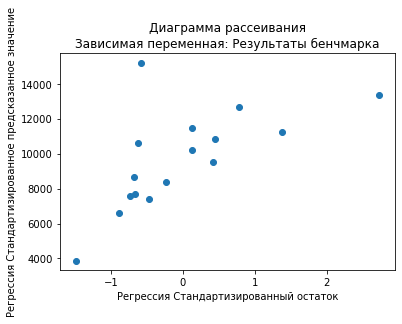

In [341]:
#Диаграмма рассеивания остатков
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal
plt.scatter(standardized_residuals,df["benchmark"])
plt.title("Диаграмма рассеивания\nЗависимая переменная: Результаты бенчмарка")
plt.xlabel("Регрессия Стандартизированный остаток")
plt.ylabel("Регрессия Стандартизированное предсказанное значение")


/home/diadact/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimens

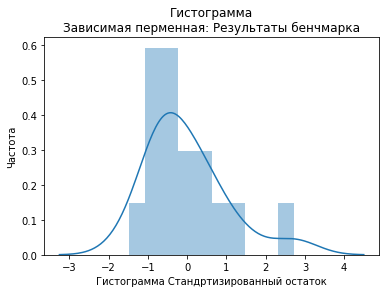

In [342]:
from scipy import stats
import numpy as np
import seaborn as sns
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal
plt.title("Гистограмма\nЗависимая перменная: Результаты бенчмарка")
plt.xlabel("Гистограмма Стандртизированный остаток")
plt.ylabel("Частота")

sns.distplot(standardized_residuals, bins = 10)


In [343]:
from math import sqrt
import scipy.stats
#F - test
print("Тест RESET Рамсея")
print(sm.stats.diagnostic.linear_reset(model, power=2, use_f = True))
# R^2
print("\nR =",sqrt(model.rsquared))
print("R^2 = ",model.rsquared)
print("Cкорректированный R^2=",model.rsquared_adj)

print("\nF - статистика = ",model.fvalue)
f_crit = scipy.stats.f.ppf(q = model.f_pvalue, dfn=2,dfd = 16)
print("F критическое =",f_crit)



/home/diadact/.local/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


Тест RESET Рамсея
<F test: F=0.8229848182426127, p=0.3821651284216714, df_denom=12, df_num=1>

R = 0.7531478907459253
R^2 =  0.5672317453350362
Cкорректированный R^2= 0.5006520138481187

F - статистика =  8.519585956072735
F критическое = 0.004332292709136186


In [344]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
if model.fvalue <f_crit:
    print("Так как F - статистика < критического значения (",f_crit,"), Модель не правильно специфицирована")
else:
    print("Так как F - статистика >= критического значения (",f_crit,"), Модель правильно специфицирована")
    # VIF
    vif = pd.DataFrame()
    vif["predictors"] = model.params.index
    vif ["VIF values"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
    print(vif)
    if max(vif["VIF values"])>=10:
        print("Присутствует мульиколлинеарность")
    else:
        print("Мультиколлинеарность не присутствует")
        dw = sm.stats.stattools.durbin_watson(model.resid)
        print("\nЗначение критерия Дурбина - Уотсона: ", dw)
        if abs(4 - dw) < abs(2 - dw):
            print("Отрицательная автокорреляция")
        elif dw < abs(2 - dw):
            print("Положительная автокорреляция")
        else:
            print("Остатки независимы")
            #print(model.summary())
            sh = shapiro(model.resid)
            print("\nЗначение критерия Шапиро", sh.statistic, "Значение коэффициента p", sh.pvalue)
            if sh.pvalue<0.05:
                print("Остатки не распределены нормально (p<0.05)")
            else:
                print("Нет оснований отвергнуть гипотезу о том, что остатки распределены номрально  (p>=0.05)")


Так как F - статистика >= критического значения ( 0.004332292709136186 ), Модель правильно специфицирована
                      predictors  VIF values
0                          const    7.003699
1                Количество ядер    5.045006
2  Объем кэша L3 процессора (Кб)    5.045006
Мультиколлинеарность не присутствует

Значение критерия Дурбина - Уотсона:  2.5728555595373153
Остатки независимы

Значение критерия Шапиро 0.8917301297187805 Значение коэффициента p 0.05933097377419472
Нет оснований отвергнуть гипотезу о том, что остатки распределены номрально  (p>=0.05)
